In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np


In [3]:
DIGITS = 8

In [4]:
class DigitAdditionBinaryDataset(Dataset):
    def __init__(self, size=1000, tokenizer=None, max_length=10, used_data=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        self.targets = []

        while len(self.data) < size:
            a, b = np.random.randint(0, 2**(DIGITS)), np.random.randint(0, 2**(DIGITS))
            if used_data is None or (a, b) not in used_data:
                a_bin = bin(a)[2:]  # Convert to binary and remove '0b' prefix
                b_bin = bin(b)[2:]
                sum_bin = bin(a + b)[2:]

                self.data.append((a_bin.zfill(DIGITS+1), b_bin.zfill(DIGITS+1)))
                self.targets.append(sum_bin.zfill(DIGITS+1))

                if used_data is not None:
                    used_data.add((a, b))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        a_bin, b_bin = self.data[idx]
        input_text = f"{' '.join(a_bin)} + {' '.join(b_bin)}"
        target_text = ' '.join(self.targets[idx])

        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")

        inputs = {k: v.squeeze() for k, v in inputs.items()}
        targets = {k: v.squeeze() for k, v in targets.items()}

        inputs['labels'] = targets['input_ids']
        
        return inputs

MAX_LENGTH = 24  

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

used_data = set()
train_dataset_add = DigitAdditionBinaryDataset(size=49152, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
train_dataloader_add = DataLoader(train_dataset_add, batch_size=1, shuffle=True)

ood_dataset_add = DigitAdditionBinaryDataset(size=100, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
ood_dataloader_add = DataLoader(ood_dataset_add, batch_size=1, shuffle=False)

for batch in train_dataloader_add:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break

for batch in ood_dataloader_add:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break


Input IDs: ['<s>0 0 0 0 1 0 0 1 0 + 0 0 1 0 1 1 1 0 0</s><pad><pad><pad>']
Labels: ['<s>0 0 1 1 0 1 1 1 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
Input IDs: ['<s>0 0 1 0 1 0 0 1 1 + 0 1 1 0 1 1 0 1 1</s><pad><pad><pad>']
Labels: ['<s>1 0 0 1 0 1 1 1 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


In [5]:
class DigitMultiplicationBinaryDataset(Dataset):
    def __init__(self, size=1000, tokenizer=None, max_length=10, used_data=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        self.targets = []

        while len(self.data) < size:
            a, b = np.random.randint(0, 2**(DIGITS)), np.random.randint(0, 2**(DIGITS))
            if used_data is None or (a, b) not in used_data:
                a_bin = bin(a)[2:]  # Convert to binary and remove '0b' prefix
                b_bin = bin(b)[2:]
                product_bin = bin(a * b)[2:]

                self.data.append((a_bin.zfill(2*DIGITS), b_bin.zfill(2*DIGITS)))
                self.targets.append(product_bin.zfill(2*DIGITS))

                if used_data is not None:
                    used_data.add((a, b))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        a_bin, b_bin = self.data[idx]
        input_text = f"{' '.join(a_bin)} * {' '.join(b_bin)}"
        target_text = ' '.join(self.targets[idx])

        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")

        inputs = {k: v.squeeze() for k, v in inputs.items()}
        targets = {k: v.squeeze() for k, v in targets.items()}

        inputs['labels'] = targets['input_ids']
        
        return inputs

MAX_LENGTH = 36 

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

used_data = set()
train_dataset_mult = DigitMultiplicationBinaryDataset(size=49152, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
train_dataloader_mult = DataLoader(train_dataset_mult, batch_size=1, shuffle=True)

ood_dataset_mult = DigitMultiplicationBinaryDataset(size=100, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
ood_dataloader_mult = DataLoader(ood_dataset_mult, batch_size=1, shuffle=False)

for batch in train_dataloader_mult:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break

for batch in ood_dataloader_mult:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break


Input IDs: ['<s>0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 * 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1</s><pad>']
Labels: ['<s>0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
Input IDs: ['<s>0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 * 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0</s><pad>']
Labels: ['<s>0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


In [6]:
from transformers import BartForConditionalGeneration, BartConfig
config = BartConfig(
    encoder_layers=1,
    encoder_ffn_dim=2,
    encoder_attention_heads=1,
    decoder_layers=2,
    decoder_ffn_dim=512,
    decoder_attention_heads=2,
    d_model=128,
)

model_add = BartForConditionalGeneration(config)
model_add.resize_token_embeddings(len(tokenizer))

model_mult = BartForConditionalGeneration(config)
model_mult.resize_token_embeddings(len(tokenizer))

BartScaledWordEmbedding(50265, 128, padding_idx=1)

In [8]:
def compute_metrics(eval_pred):
    total = 0
    correct = 0
    logits, labels = eval_pred
    predictions = np.argmax(logits[0], axis=-1)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Calculate accuracy using the loaded metric
    for prediction, label in zip(predictions , labels):
                if torch.equal(torch.from_numpy(prediction), torch.from_numpy(label)):
                    correct += 1

                total += 1

    accuracy = correct / total if total > 0 else 0
    
    return {"accuracy": accuracy}

In [9]:
training_args = TrainingArguments(
    output_dir='../results',       
    report_to="none",
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    num_train_epochs=5000,             
    logging_dir='./logs',
    gradient_accumulation_steps=8,
    bf16=True,
    learning_rate = 0.001,
    dataloader_num_workers=16,
    evaluation_strategy="steps",
    logging_steps = 250,
    eval_steps = 250,
    save_strategy="no" 
    
)

subset_indices = list(range(100)) 
dataset_mult_subset = Subset(train_dataset_mult, subset_indices)

subset_indices = list(range(100)) 
dataset_add_subset = Subset(train_dataset_add, subset_indices)

trainer_add = Trainer(
    model=model_add,
    args=training_args,
    train_dataset=train_dataset_add,
    eval_dataset=dataset_add_subset, # change to ood_dataset_add for OOD testing
    compute_metrics=compute_metrics
)

trainer_mult = Trainer(
    model=model_mult,
    args=training_args,
    train_dataset=train_dataset_mult,
    eval_dataset=dataset_mult_subset, # change to ood_dataset_mult for OOD testing
    compute_metrics=compute_metrics
)

/local/aabavandpour/anaconda3/envs/sens/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_add.train()

In [ ]:
trainer_mult.train()

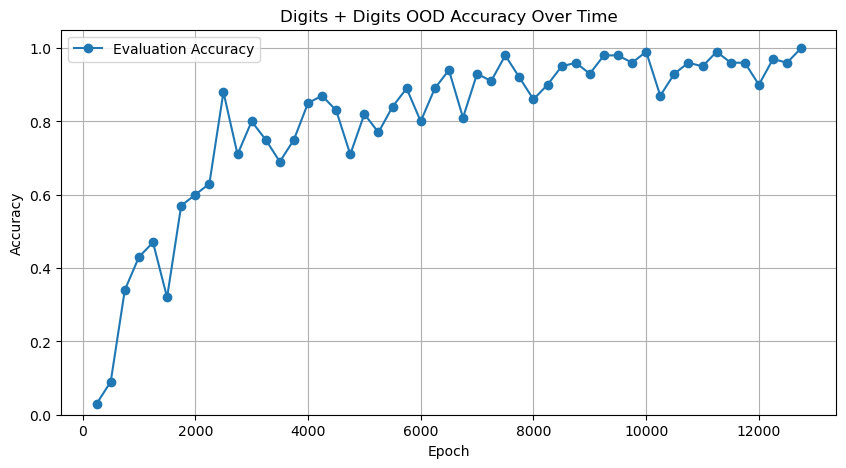

'./results/accuracy_data_6sum_bin_iid.pkl'

In [10]:
#for addition
train_accuracy_history_add = []
eval_accuracy_history_add = []
train_steps_add = []
eval_steps_add = []

for log in trainer_add.state.log_history:
    if 'accuracy' in log:
        train_accuracy_history_add.append(log['accuracy'])
        train_steps_add.append(log['step'])  # Track training steps
    if 'eval_accuracy' in log:
        eval_accuracy_history_add.append(log['eval_accuracy'])
        eval_steps_add.append(log['step'])  # Track evaluation steps

plt.figure(figsize=(10, 5))
plt.plot(eval_steps_add, eval_accuracy_history_add, marker='o', linestyle='-', label="Evaluation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Digits + Digits OOD Accuracy Over Time")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.show()

data_dict = {
    "train_accuracy_history_add": train_accuracy_history_add,
    "eval_accuracy_history_add": eval_accuracy_history_add,
    "train_steps_add": train_steps_add,
    "eval_steps_add": eval_steps_add
}

file_path = "./results/accuracy_data_8sum_bin_iid.pkl"
with open(file_path, "wb") as f:
    pickle.dump(data_dict, f)

file_path


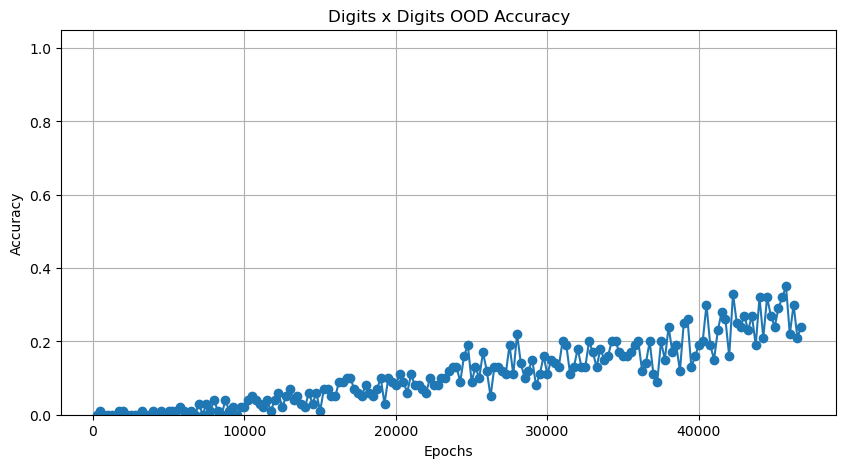

'./results/accuracy_data_8mult_bin_iid.pkl'

In [11]:
#For multiplication
train_accuracy_history_mult = []
eval_accuracy_history_mult = []
train_steps_mult = []
eval_steps_mult = []

for log in trainer_mult.state.log_history:
    if 'accuracy' in log:
        train_accuracy_history_mult.append(log['accuracy'])
        train_steps_mult.append(log['step']) 
    if 'eval_accuracy' in log:
        eval_accuracy_history_mult.append(log['eval_accuracy'])
        eval_steps_mult.append(log['step']) 

plt.figure(figsize=(10, 5))

if eval_accuracy_history_mult:
    plt.plot(eval_steps_mult, eval_accuracy_history_mult, marker='o', linestyle='-')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Digits x Digits OOD Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

data_mult_dict = {
    "train_accuracy_history_mult": train_accuracy_history_mult,
    "eval_accuracy_history_mult": eval_accuracy_history_mult,
    "train_steps_mult": train_steps_mult,
    "eval_steps_mult": eval_steps_mult
}
import pickle
file_path_mult = "./results/accuracy_data_8mult_bin_iid.pkl"
with open(file_path_mult, "wb") as f:
    pickle.dump(data_mult_dict, f)

file_path_mult


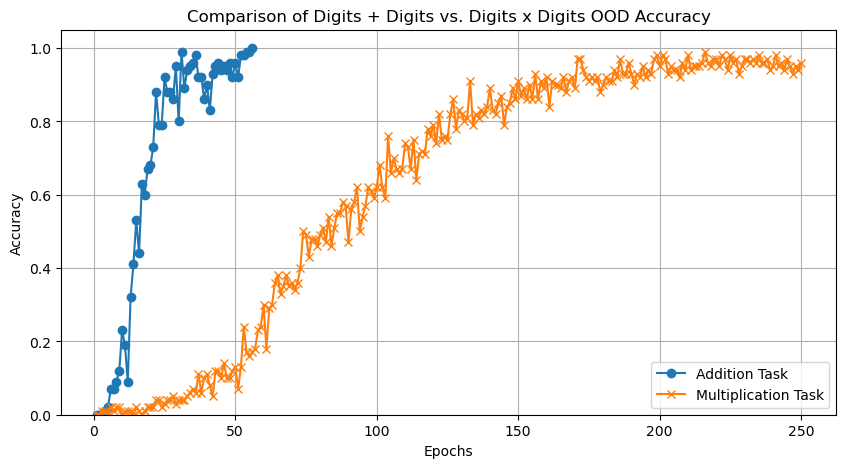

In [13]:
import pickle
import matplotlib.pyplot as plt

# Load accuracy data for addition
file_path_add = "./results/accuracy_data_2sum.pkl"
with open(file_path_add, "rb") as f:
    data_add = pickle.load(f)

# Load accuracy data for multiplication
file_path_mult = "./results/accuracy_data_2mult.pkl"
with open(file_path_mult, "rb") as f:
    data_mult = pickle.load(f)

# Extract evaluation accuracy and steps
eval_accuracy_add = data_add["eval_accuracy_history_add"]
eval_steps_add = data_add["eval_steps_add"]

eval_accuracy_mult = data_mult["eval_accuracy_history_mult"]
eval_steps_mult = data_mult["eval_steps_mult"]

# Plot the accuracy comparison
plt.figure(figsize=(10, 5))

plt.plot(eval_steps_add, eval_accuracy_add, marker='o', linestyle='-', label="Addition Task")
plt.plot(eval_steps_mult, eval_accuracy_mult, marker='x', linestyle='-', label="Multiplication Task")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Comparison of Digits + Digits vs. Digits x Digits OOD Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.show()


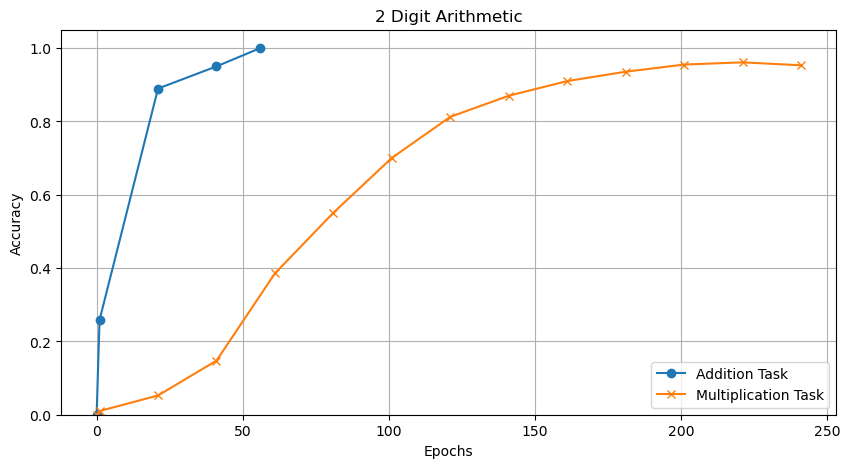

In [12]:
file_path_add = "./results/accuracy_data_2sum.pkl"
with open(file_path_add, "rb") as f:
    data_add = pickle.load(f)

file_path_mult = "./results/accuracy_data_2mult.pkl"
with open(file_path_mult, "rb") as f:
    data_mult = pickle.load(f)

def group_by_epochs(steps, accuracies, bin_size=20, ensure_zero=True, ensure_end_value=None):
    grouped_steps = []
    grouped_accuracies = []
    
    if len(steps) == 0:
        return grouped_steps, grouped_accuracies
    
    min_epoch = min(steps)
    max_epoch = max(steps)
    bins = np.arange(min_epoch, max_epoch + bin_size, bin_size)

    for i in range(len(bins) - 1):
        indices = [idx for idx, step in enumerate(steps) if bins[i] <= step < bins[i+1]]
        if indices:
            avg_accuracy = np.mean([accuracies[idx] for idx in indices])
            grouped_steps.append(bins[i])
            grouped_accuracies.append(avg_accuracy)
    
    if ensure_zero and (0 not in grouped_steps):
        grouped_steps.insert(0, 0)
        grouped_accuracies.insert(0, 0.0)

    if ensure_end_value is not None:
        if grouped_steps[-1] != max_epoch:
            grouped_steps.append(max_epoch)
            grouped_accuracies.append(ensure_end_value)
        else:
            grouped_accuracies[-1] = ensure_end_value

    return grouped_steps, grouped_accuracies

# Group data for addition and multiplication
grouped_steps_add, grouped_accuracy_add = group_by_epochs(
    data_add["eval_steps_add"], 
    data_add["eval_accuracy_history_add"], 
    bin_size=20, 
    ensure_zero=True, 
    ensure_end_value=1.0  # Ensure sum model ends at 1.0 accuracy
)

grouped_steps_mult, grouped_accuracy_mult = group_by_epochs(
    data_mult["eval_steps_mult"], 
    data_mult["eval_accuracy_history_mult"], 
    bin_size=20, 
    ensure_zero=True
)

# Plot the accuracy comparison
plt.figure(figsize=(10, 5))

plt.plot(grouped_steps_add, grouped_accuracy_add, marker='o', linestyle='-', label="Addition Task")
plt.plot(grouped_steps_mult, grouped_accuracy_mult, marker='x', linestyle='-', label="Multiplication Task")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("2 Digit Arithmetic")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.show()
